In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow.keras
import cv2 as cv
import PIL as pil
import matplotlib.pyplot as plt
import os

from segmentation_models import Unet
from segmentation_models import get_preprocessing
from segmentation_models.metrics import iou_score

from scipy import ndimage

Using TensorFlow backend.


Segmentation Models: using `keras` framework.


Working with JSRT Database for heart and lungs segmentation.

In [2]:
# import all Normal scans
masks_path = 'Normal1/img/' 

masks = []
masks_name = []

for name in os.listdir(masks_path):
    image = ndimage.imread(masks_path+name)
    masks_name.append(name)
    masks.append(image)



/home/marina/.local/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0.
Use ``matplotlib.pyplot.imread`` instead.
  


In [266]:
shape = (2048, 2048)
dtype = np.dtype('>u2')
all_images = []

for name in masks_name:
    image = np.fromfile(open('All247images/'+name[:-3]+'IMG', 'rb'), np.dtype('>u2')).reshape((2048, 2048))
    all_images.append(image)
    


In [4]:
from keras.preprocessing import image as iimage
from keras.applications.resnet50 import preprocess_input, decode_predictions


input_data=[]
input_masks=[]
for i in range(0, len(all_images)):
    x = cv.resize(all_images[i], (224, 224), interpolation = cv.INTER_AREA) 
    y = cv.resize(masks[i], (224, 224), interpolation = cv.INTER_AREA) 
    
    x = np.repeat(x[..., np.newaxis], 3, -1)
    y = np.repeat(y[..., np.newaxis], 3, -1)
    
    x = preprocess_input(x)
    input_masks.append(y)
    input_data.append(x)

In [6]:
from segmentation_models import losses
from segmentation_models import metrics
from keras.optimizers import RMSprop
from keras.layers import LeakyReLU
from keras.activations import hard_sigmoid


preprocess_input = get_preprocessing('resnet34')

loss = losses.JaccardLoss()
metric = metrics.FScore()
optimizer = RMSprop(learning_rate=0.0001, rho=0.8)
# activation = hard_sigmoid()

x_train, x_val = input_data[:-14], input_data[-14:-4]
y_train, y_val = input_masks[:-14], input_masks[-14:-4]

x_train = preprocess_input(x_train)
x_val = preprocess_input(x_val)

model = Unet('resnet34', encoder_weights='imagenet', activation='hard_sigmoid')
model.compile(optimizer, loss=loss, metrics=[metric])

model.fit(
    x=x_train,
    y=y_train,
    batch_size=16,
    epochs=20,
    validation_data=(x_val, y_val),
    verbose=2,
)

Train on 79 samples, validate on 10 samples
Epoch 1/20
 - 70s - loss: -1.3278e+00 - f1-score: 1.3621 - val_loss: -1.0790e+01 - val_f1-score: 1.8462
Epoch 2/20
 - 56s - loss: -4.1574e+00 - f1-score: 1.6677 - val_loss: -4.1566e+00 - val_f1-score: 1.6800
Epoch 3/20
 - 65s - loss: -7.8978e+00 - f1-score: 1.7796 - val_loss: -6.5077e+00 - val_f1-score: 1.7699
Epoch 4/20
 - 50s - loss: -1.7793e+01 - f1-score: 1.8884 - val_loss: -1.8787e+01 - val_f1-score: 1.9072
Epoch 5/20
 - 51s - loss: -3.2797e+01 - f1-score: 1.9358 - val_loss: -4.7859e+00 - val_f1-score: 1.7095
Epoch 6/20
 - 50s - loss: -4.3489e+01 - f1-score: 1.9508 - val_loss: -5.8383e+00 - val_f1-score: 1.7487
Epoch 7/20
 - 51s - loss: -5.1513e+01 - f1-score: 1.9567 - val_loss: -1.4471e+01 - val_f1-score: 1.8825
Epoch 8/20
 - 51s - loss: -5.3234e+01 - f1-score: 1.9577 - val_loss: -2.6400e+01 - val_f1-score: 1.9325
Epoch 9/20
 - 52s - loss: -5.4471e+01 - f1-score: 1.9585 - val_loss: -2.9645e+01 - val_f1-score: 1.9391
Epoch 10/20
 - 51s -

In [7]:

p = model.predict(input_data[-4:])

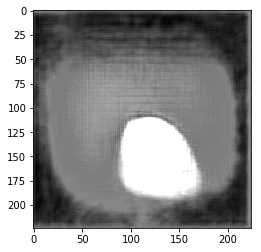

In [221]:
plt.imshow(p[2][:, :, 0], cmap='gray')

True

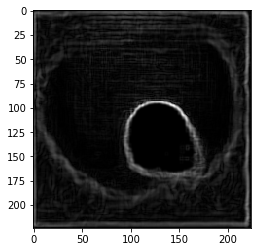

In [222]:
from scipy.ndimage import sobel

sobelx =  sobel(p[0], axis=0)
grad_x = cv.Sobel(p[0], cv.CV_64F, 1, 0, ksize=5)
# cv.imshow('title', sobelx)
plt.imshow(grad_x, cmap='gray')
# plt.show()
cv.imwrite('sobel.png', grad_x)

sobely =  sobel(p[0], axis=0)
grad_y = cv.Sobel(p[0], cv.CV_64F, 0, 1, ksize=5)
# cv.imshow('title', sobelx)
plt.imshow(abs(grad_y)+abs(grad_x), cmap='gray')
# plt.show()
cv.imwrite('sobel.png', abs(grad_y)+abs(grad_x))

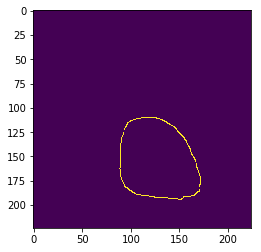

In [267]:
from skimage.feature import canny

edges = canny(
    image=p[-2][:, :, 0],
    sigma=2,
    low_threshold=0.1,
    high_threshold=0.5,
)

plt.imshow(edges)

In [11]:
l1_masks_path = 'Normal1/lungs1/'
l2_masks_path = 'Normal1/lungs2/'
from scipy import ndimage

l_masks = []
l_masks_name = []

for name in os.listdir(l1_masks_path):
    image1 = ndimage.imread(l1_masks_path+name)
    image2 = ndimage.imread(l2_masks_path+name)

    l_masks_name.append(name)
    l_masks.append(image1+image2)

/home/marina/.local/lib/python3.7/site-packages/ipykernel_launcher.py:9: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0.
Use ``matplotlib.pyplot.imread`` instead.
  if __name__ == '__main__':
/home/marina/.local/lib/python3.7/site-packages/ipykernel_launcher.py:10: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0.
Use ``matplotlib.pyplot.imread`` instead.
  # Remove the CWD from sys.path while we load stuff.


In [13]:

l_input_masks=[]
for i in range(0, len(all_images)):

    y = cv.resize(l_masks[i], (224, 224), interpolation = cv.INTER_AREA) 

    y = np.repeat(y[..., np.newaxis], 3, -1)

    l_input_masks.append(y)


In [14]:
l_input_masks = np.array(l_input_masks)

In [15]:

y_train, y_val = l_input_masks[:-14], l_input_masks[-14:-4]


# define model
model2 = Unet(BACKBONE, encoder_weights='imagenet', activation='hard_sigmoid')
model2.compile(optimizer, loss=loss, metrics=[metric])

# fit model
model2.fit(
    x=x_train,
    y=y_train,
    batch_size=16,
    epochs=20,
    validation_data=(x_val, y_val),
    verbose=2,
)

Train on 79 samples, validate on 10 samples
Epoch 1/20
 - 60s - loss: -2.5450e+00 - f1-score: 1.5356 - val_loss: -2.3328e+00 - val_f1-score: 1.5314
Epoch 2/20
 - 57s - loss: -7.2170e+00 - f1-score: 1.7659 - val_loss: -1.3269e+00 - val_f1-score: 1.3932
Epoch 3/20
 - 52s - loss: -1.9478e+01 - f1-score: 1.8897 - val_loss: -1.2438e+00 - val_f1-score: 1.3781
Epoch 4/20
 - 52s - loss: -4.9408e+01 - f1-score: 1.9444 - val_loss: -2.2057e+00 - val_f1-score: 1.5181
Epoch 5/20
 - 51s - loss: -1.0834e+02 - f1-score: 1.9676 - val_loss: -1.1394e+00 - val_f1-score: 1.3579
Epoch 6/20
 - 52s - loss: -2.2717e+02 - f1-score: 1.9778 - val_loss: -8.4188e-01 - val_f1-score: 1.2918
Epoch 7/20
 - 52s - loss: -3.0344e+02 - f1-score: 1.9805 - val_loss: -8.2408e-01 - val_f1-score: 1.2876
Epoch 8/20
 - 52s - loss: -3.3233e+02 - f1-score: 1.9808 - val_loss: -1.0161e+00 - val_f1-score: 1.3326
Epoch 9/20
 - 50s - loss: -3.6997e+02 - f1-score: 1.9813 - val_loss: -1.4543e+00 - val_f1-score: 1.4162
Epoch 10/20
 - 52s -

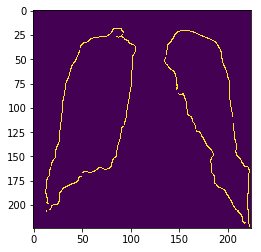

In [268]:
p2 = model2.predict(input_data[-4:])
from skimage.feature import canny

edges2 = canny(
    image=p2[-2][:, :, 0],
    sigma=2,
    low_threshold=0.1,
    high_threshold=0.3,
)

plt.imshow(edges2)

In [269]:
ed_heart = np.array(edges*255).astype(np.float32)
ed_lungs = np.array(edges2*255).astype(np.float32)

In [270]:

left_h, right_h = 0, 0

for col in range(edges.shape[0]):
    if(np.max(edges[:, col])):
        left_line_h = np.argmax(edges[:, col])
        left_h = col
        break
# print(left_line_h, left_h)
for col in range(edges.shape[0]-1, 0, -1):
    if(np.max(edges[:, col])):
        right_line_h = np.argmax(edges[:, col])
        right_h = col
        break
# print(right_line_l, right_h)

In [271]:
distances = []
for line in range(edges2.shape[0]):
    if(edges2[line].any()):
        max_ind = np.where(edges2[line]==max(edges2[line]))
        distances.append([max_ind[0][0], max_ind[0][-1], max_ind[0][-1]-max_ind[0][0]])

distances = np.array(distances)


In [272]:
max_dist_arg = np.argmax(distances[:, 2])
print(distances[max_dist_arg])

[ 12 221 209]


In [273]:
crt_index = (right_h-left_h)/distances[max_dist_arg][2]
print(crt_index)

0.4019138755980861


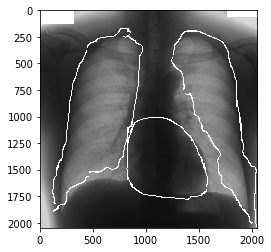

In [274]:

heart = cv.resize(np.array(ed_heart), dsize=(2048, 2048), interpolation = cv.INTER_AREA)
lungs = cv.resize(np.array(ed_lungs), dsize=(2048, 2048), interpolation = cv.INTER_AREA)

m = np.max(all_images[-2])

for i in range(0, 2048):
    for j in range(0, 2048):
        if heart[i][j]:
            all_images[-2][i][j] = m+1
        if lungs[i][j]:
            all_images[-2][i][j] = m+1
            
img = all_images[-2]/np.max(all_images[-2])
plt.imshow(img, cmap='gray')
# cv.imwrite('test.png', img)